# Deep learning for computer vision

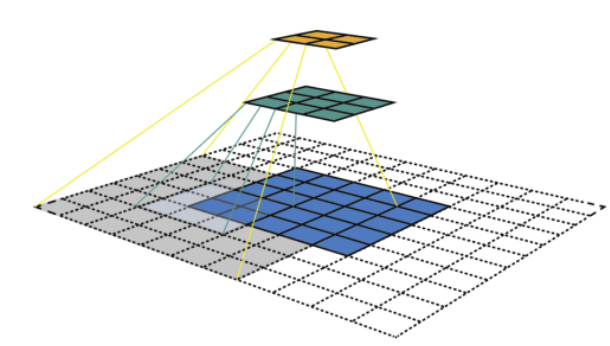

This notebook will teach you to build and train convolutional networks for image recognition.

In [ ]:
import os
import time
import tqdm
import torch
import functools
import numpy as np
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])

ds1 = datasets.FashionMNIST("../../data", train=True, download=True, transform=transform)
ds_test = datasets.FashionMNIST("../../data", train=False, download=True, transform=transform)

ds_train, ds_val = torch.utils.data.random_split(ds1, [50000, 10000])

trainloader = torch.utils.data.DataLoader(ds_train, batch_size=32,
                                        shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(ds_val, batch_size=10000,
                                        shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(ds_test, batch_size=10000,
                                        shuffle=False, num_workers=2)


print("Training+Val:", ds1,
     "\nTest:", ds_test)

**Fashion-MNIST** is a 10-class dataset of 28x28 grayscale images of various kind of fashion items (Zalando's article items). Named after the famous MNIST dataset with hand-written digits. Lets display a few of them.

In [ ]:
# helper function to show an image
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

Checking for available GPU device.

In [ ]:
def get_free_gpu():
    from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo, nvmlDeviceGetCount
    nvmlInit()

    return np.argmax([
        nvmlDeviceGetMemoryInfo(nvmlDeviceGetHandleByIndex(i)).free
        for i in range(nvmlDeviceGetCount())
    ])

if torch.cuda.is_available():
    cuda_id = get_free_gpu()
    device = 'cuda:%d' % (get_free_gpu(), )
    print('Selected %s' % (device, ))
else:
    device = 'cpu'
    print('WARNING: using cpu!')

### please, don't remove the following line
x = torch.tensor([1], dtype=torch.float32).to(device)

# Building a baseline network

Simple neural networks with layers applied on top of one another can be implemented either as `torch.nn.Sequential` or as a subclass of `torch.nn.Module`. 

__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3)`__

__`nn.MaxPool2d(kernel_size)`__

Let's start with a simple baseline:

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(676, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = Net().to(device)

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [ ]:
def model_count_params(model):
    return np.sum([s.numel() for s in model.parameters()])

In [ ]:
writer = SummaryWriter('runs/F-MNIST_CNN-1')

In [ ]:

writer.add_scalar("model/size", model_count_params(model))
print("Model size:", model_count_params(model))
writer.add_graph(model, images.to(device))

In [ ]:
def accuracy(y_true, y_pred):
    """
    calculates the accuracy of the prediction
    y_true is N-vector of integers for N-item batch
    y_pred is a tensor N x 10 of 10-dimensional network component output
    
    You have to find the number of the highest component output
    and compare it with y_true and compute average number of exact matches.
    
    Returs: average number of exact matches 
    """
    # to find maximum item in the tensor along i dimension use .max(dim=i)
    # to count number of matching items use '==' operator
    # 
    # your code here
    raise NotImplementedError
    
    return accuracy

In [ ]:
assert accuracy(torch.ones(1000), torch.rand(1000,2)) > 0.4 
assert accuracy(torch.ones(1000), torch.rand(1000,2)) < 0.6
assert accuracy(torch.ones(10), torch.cat([torch.ones(10,1), torch.zeros(10,1)], dim=1)) == 0
assert accuracy(torch.ones(10), torch.cat([torch.zeros(10,1), torch.ones(10,1)], dim=1)) == 1


In [ ]:
def train(model, writer, num_epochs=1, device=device):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    train_loss = []
    test_accuracy = []
    running_loss = 0
    epoch_iter = tqdm.trange(num_epochs)
    for epoch in epoch_iter:
        for i, data in enumerate(trainloader, 0):

            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = map(lambda x: x.to(device), data)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                writer.add_scalar('Loss/training',
                                running_loss / 1000,
                                epoch * len(trainloader) + i)
                running_loss = 0.0
        
        for X_batch, y_batch in DataLoader(ds_val, batch_size=len(ds_val)):
            test_accuracy.append(
                accuracy(
                    y_batch.to(device),
                    model(X_batch.to(device))))

        writer.add_scalar('Loss/val',
                            test_accuracy[-1],
                            epoch)
        epoch_iter.set_description(f"Accuracy: {test_accuracy[-1]:.3f}")

In [ ]:
train(model, writer, num_epochs=5)

### Final test

In [ ]:
def test_model(model, writer):
    test_accuracy = 0
    model.train(False) 
    with torch.no_grad():
        for X_batch, y_batch in DataLoader(ds_test, batch_size=len(ds_test)):
            test_accuracy = 100 * accuracy(y_batch.to(device), model(X_batch.to(device)))


    print("Final results:")
    print(f"  test accuracy:\t\t{test_accuracy:.2f}")

    if test_accuracy > 98:
        print("U'r freakin' amazin'!")
    elif test_accuracy > 95:
        print("Achievement unlocked: 110lvl Warlock!")
    elif test_accuracy > 90:
        print("Achievement unlocked: 80lvl Warlock!")
    elif test_accuracy > 85:
        print("Achievement unlocked: 70lvl Warlock!")
    else:
        print("We need more magic! Follow instructons below")
    writer.add_scalar("Loss/test", test_accuracy)
    return test_accuracy

In [ ]:

%time acc = test_model(model, writer)
assert acc > 80
writer.close()


## Task: improve convolution net

Let's create a mini-convolutional network with an architecture like this:

* 3x3 convolution with 8 filters, padding=1 and _ReLU_ activation
* 2x2 pooling
* 3x3 convolution with 16 filters, padding=1 and _ReLU_ activation
* 4x4 pooling
* flatten
* Linear layer with ~180 input and ~100 output sizes and _ReLU_ activation
* output linear layer


To find the size of the 1st linear layer you can run the cell below and 
if it throws error like this: 

    RuntimeError: size mismatch, m1: [32 x 784], m2: [144 x 100], 
  
you should change the size of the Linear layer to 784.

Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with default params (feel free to modify the `train` procedure above).


__HACK_OF_THE_DAY__: the number of channels must be in the order of the number of class_labels

In [ ]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        # put all the layer initialization here
        # your code here
        raise NotImplementedError

    def forward(self, x):
        # pass x through all the layers
        # your code here
        raise NotImplementedError
        return x
    
model2 = Net2().to(device)

## Train it ##

In [ ]:
writer2 = SummaryWriter('runs/F-MNIST_CNN-redux-6')
writer2.add_scalar("model/size", model_count_params(model2))
writer2.add_graph(model2, images.to(device))
writer2.close()

In [ ]:
model_count_params(model2)

In [ ]:
train(model2, writer2, num_epochs=20)

## Test it

In [ ]:
%time accuracy = test_model(model2, writer2);
writer2.close()
assert accuracy > 90

Hopefully you've managed to succeed. If not, you may always come back to this task after looking at at more advanced topics, e.g. regularization and batch normalization.